In [1]:
include("../src/JuliaMBD.jl")

Main.JuliaMBD

In [2]:
using DifferentialEquations
using Plots
using .JuliaMBD
using .JuliaMBD.Diagram

In [3]:
@model DCMotorDisk begin
    @parameter begin
        R = 5.7
        L = 0.2
        K_e = 7.16e-2
        K_tau = 7.2e-2
        J_M = 1.1e-4
        J_I = 1.3e-3
        D = 6.0e-5
    end
    @xmlmodel("mbd2.drawio", "DCMotorDisk")
end


DCMotorDisk (generic function with 1 method)

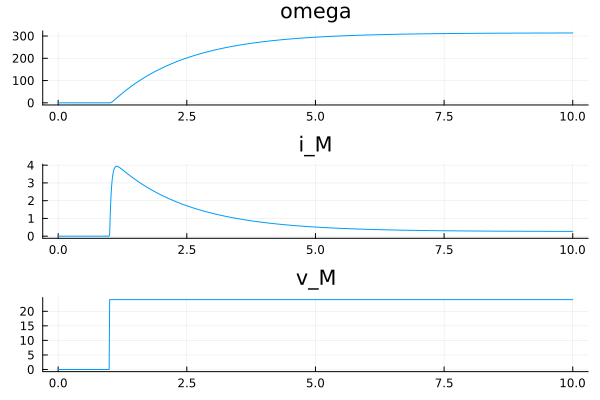

In [4]:
@model Test begin
    @block begin
        s = Step(steptime=1, finalvalue=24)
        m = DCMotorDisk()
    end
    @connect begin
        s.out => m.v_M
    end
    @scope begin
        m.omega => omega
        m.i_M => i_M
        m.v_M => v_M
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,10))
plot(res)

In [5]:
@model Tachogenerator begin
    @parameter begin
        alpha_T = 1.5/1000
    end
    @xmlmodel("mbd2.drawio", "Tachogenerator")
end

Tachogenerator (generic function with 1 method)

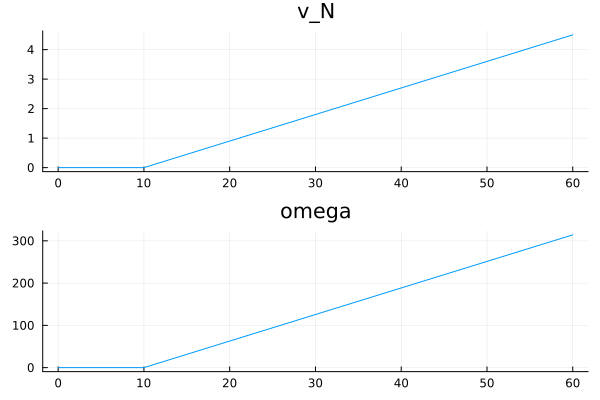

In [6]:
@model Test begin
    @parameter omega_d = 2*pi
    @block begin
        s = Ramp(slope=omega_d, starttime=10)
        m = Tachogenerator()
    end
    @connect begin
        s.out => m.omega
    end
    @scope begin
        m.v_N => v_N
        m.omega => omega
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,60))
plot(res)

In [7]:
@model MotorDriver begin
    @parameter begin
        alpha_i = 5/37.5
    end
    @xmlmodel("mbd2.drawio", "MotorDriver")
end

MotorDriver (generic function with 1 method)

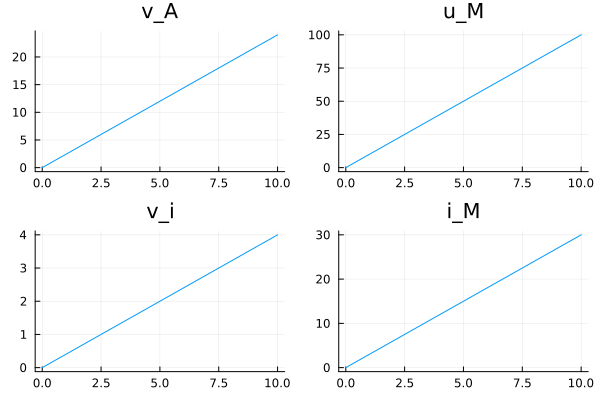

In [8]:
@model Test begin
    @parameter begin
        Vs = 24
        u_M_d = 10
        i_M_d = 3
    end
    @block begin
        s1 = Constant(value=Vs)
        s2 = Ramp(slope=u_M_d)
        s3 = Ramp(slope=i_M_d)
        m = MotorDriver()
    end
    @connect begin
        s1.out => m.Vs
        s2.out => m.u_M
        s3.out => m.i_M
    end
    @scope begin
        m.v_A => v_A
        m.u_M => u_M
        m.v_i => v_i
        m.i_M => i_M
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,10))
plot(res, layout=(2,2))

In [57]:
@model PlantModel begin
    @parameter begin
        Vs = 24
    end
    @xmlmodel("mbd2.drawio", "PlantModel2")
end

PlantModel (generic function with 1 method)

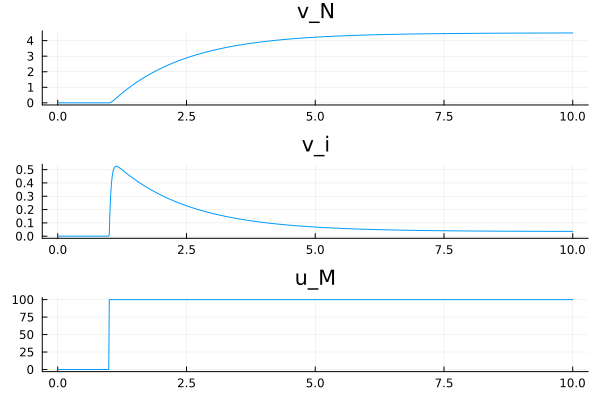

In [58]:
@model Test begin
    @parameter begin
        u_MD = 100
    end
    @block begin
        s1 = Step(steptime=1, finalvalue=u_MD)
        m = PlantModel()
    end
    @connect begin
        s1.out => m.u_M
    end
    @scope begin
        m.v_N => v_N
        m.v_i => v_i
        m.u_M => u_M
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,10))
plot(res)

In [59]:
@model ADConverter begin
    @parameter begin
        n = 10
        V_A_max = 5
        V_A_min = 0
        alpha_A = (2^n-1)/(V_A_max - V_A_min)
    end
    @xmlmodel("mbd2.drawio", "ADConverter")
end

ADConverter (generic function with 1 method)

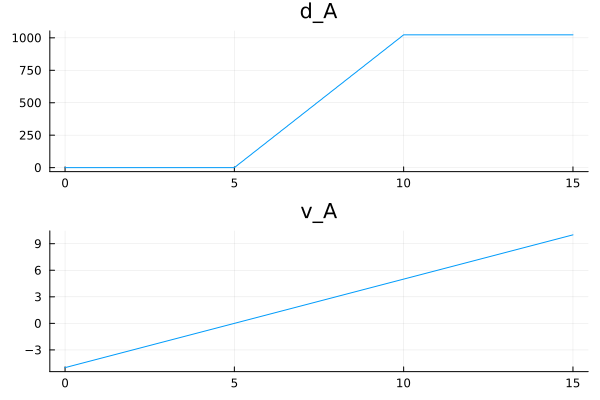

In [60]:
@model Test begin
    @parameter begin
        u_A_d = 1
    end
    @block begin
        s1 = Ramp(slope=u_A_d, starttime=0, initialoutput=-5)
        m = ADConverter()
    end
    @connect begin
        s1.out => m.v_A
    end
    @scope begin
        m.d_A => d_A
        m.v_A => v_A
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,15))
plot(res)

In [61]:
@model PulseGenerator2 begin
    @parameter begin
        m = 8
        alpha_P = 100/(2^m-1)
    end
    @xmlmodel("mbd2.drawio", "PulseGenerator")
end

PulseGenerator2 (generic function with 1 method)

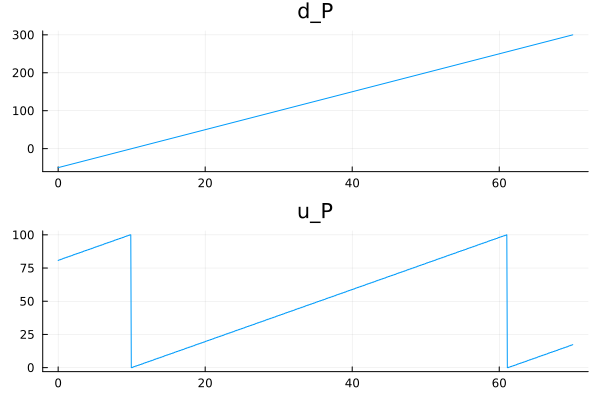

In [62]:
@model Test begin
    @parameter begin
        d_P_d = 5
    end
    @block begin
        s1 = Ramp(slope=d_P_d, starttime=0, initialoutput=-50)
        m = PulseGenerator2()
    end
    @connect begin
        s1.out => m.d_P
    end
    @scope begin
        m.d_P => d_P
        m.u_P => u_P
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,70))
plot(res)

In [63]:
@model Decoder begin
    @parameter begin
        alpha_T = 1.5/1000
        alpha_i = 5/37.5
        n = 10
        V_A_max = 5
        V_A_min = 0
        alpha_A = (2^n-1)/(V_A_max - V_A_min)
    end
    @xmlmodel("mbd2.drawio", "Decoder")
end


Decoder (generic function with 1 method)

In [64]:
@model Encoder begin
    @parameter begin
        m = 8
        u_max = 100
        u_min = 0
    end
    @xmlmodel("mbd2.drawio", "Encoder")
end


Encoder (generic function with 1 method)

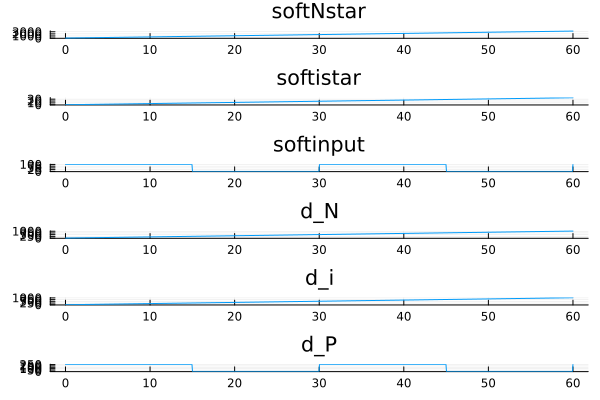

In [65]:
@model testcontroller begin
    @block begin
        in1 = Inport(:d_N)
        in2 = Inport(:d_i)
        out1 = Outport(:d_P)
        d = Decoder()
        e = Encoder()
        pg = PulseGenerator(amplitude=100, period=30, pulsewidth=50)
    end
    @connect begin
        in1.out => d.d_N
        in2.out => d.d_i
        pg.out => e.u
        e.d_P => out1.in
    end
    @scope begin
        d.Nstar => softNstar
        d.istar => softistar
        e.u => softinput
    end
end

@model Test begin
    @parameter begin
        n = 10
        d_N_d = (2^n-1)/60
        d_i_d = (2^n-1)/60
    end
    @block begin
        ramp1 = Ramp(slope=d_N_d)
        ramp2 = Ramp(slope=d_i_d)
        c = testcontroller()
    end
    @connect begin
        ramp1.out => c.d_N
        ramp2.out => c.d_i
    end
    @scope begin
        c.d_N => d_N
        c.d_i => d_i
        c.d_P => d_P
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,60))
plot(res)

In [66]:
@model ADConverters begin
    @xmlmodel("mbd2.drawio", "ADConverters")
end

ADConverters (generic function with 1 method)

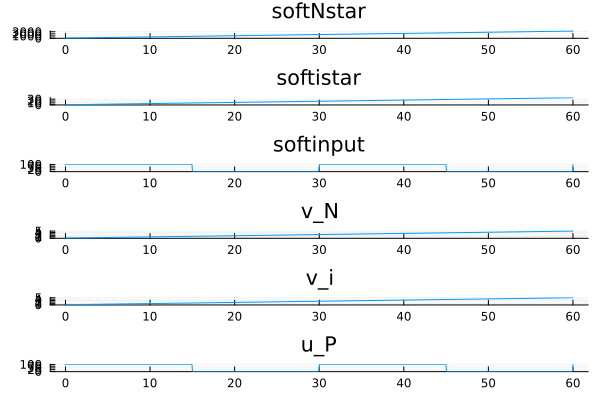

In [67]:
@model testcontroller2 begin
    @block begin
        in1 = Inport(:v_N)
        in2 = Inport(:v_i)
        out1 = Outport(:u_P)
        ad = ADConverters()
        c = testcontroller()
        pg = PulseGenerator2()
    end
    @connect begin
        in1.out => ad.v_N
        in2.out => ad.v_i
        ad.d_N => c.d_N
        ad.d_i => c.d_i
        c.d_P => pg.d_P
        pg.u_P => out1.in
    end
end

@model Test begin
    @parameter begin
        v_N_d = 5/60
        v_i_d = 5/60
    end
    @block begin
        ramp1 = Ramp(slope=v_N_d)
        ramp2 = Ramp(slope=v_i_d)
        c = testcontroller2()
    end
    @connect begin
        ramp1.out => c.v_N
        ramp2.out => c.v_i
    end
    @scope begin
        c.v_N => v_N
        c.v_i => v_i
        c.u_P => u_P
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,60))
plot(res)

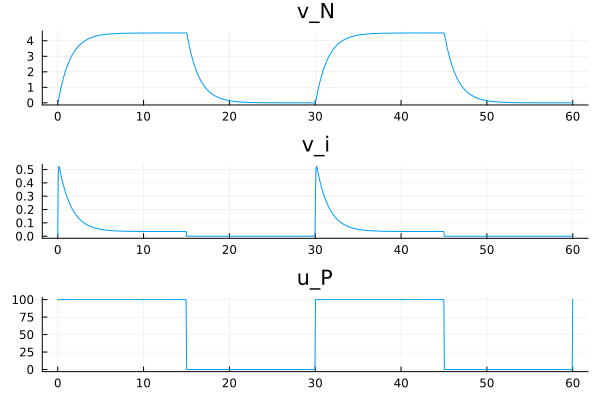

In [68]:
@model testsys begin
    @block begin
        c = testcontroller2()
        p = PlantModel()
    end
    @connect begin
        c.u_P => p.u_M
        p.v_N => c.v_N
        p.v_i => c.v_i
    end
    @scope begin
        c.v_N => v_N
        c.v_i => v_i
        c.u_P => u_P
    end
end

m = @compile testsys()
res = simulate(m, tspan=(0,60))
plot(res, vars=[:v_N, :v_i, :u_P])

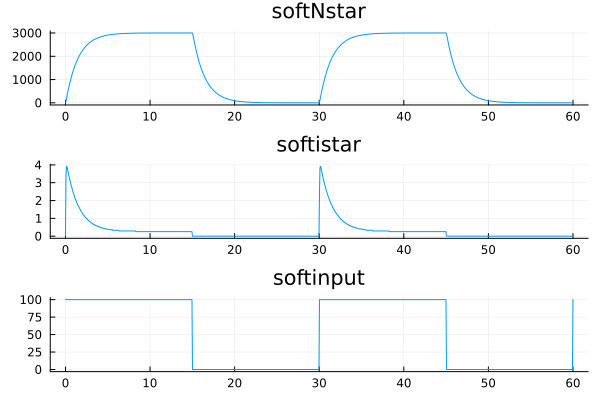

In [69]:
plot(res, vars=[:softNstar, :softistar, :softinput])

In [78]:
@model PIDControl begin
    @parameter begin
        SV = 1000
        K_P = 0.1
        K_I = 0.05
        K_D = 0.01
        u_min = 0
        u_max = 100
    end
    @xmlmodel("mbd2.drawio", "PIDControl")
end

PIDControl (generic function with 1 method)

In [73]:
@model Controller begin
    @xmlmodel("mbd2.drawio", "Controller")
end

Controller (generic function with 1 method)

In [79]:
@model testcontroller3 begin
    @block begin
        in1 = Inport(:v_N)
        in2 = Inport(:v_i)
        out1 = Outport(:u_P)
        ad = ADConverters()
        c = Controller()
        pg = PulseGenerator2()
    end
    @connect begin
        in1.out => ad.v_N
        in2.out => ad.v_i
        ad.d_N => c.d_N
        ad.d_i => c.d_i
        c.d_P => pg.d_P
        pg.u_P => out1.in
    end
end

testcontroller3 (generic function with 1 method)

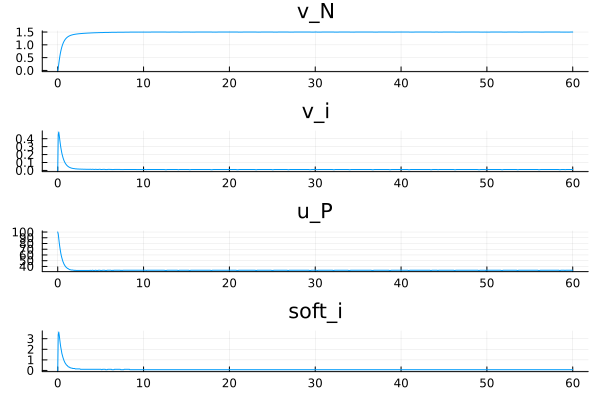

In [81]:
@model testsys3 begin
    @block begin
        c = testcontroller3()
        p = PlantModel()
        f = From(tag=:soft_i)
    end
    @connect begin
        c.u_P => p.u_M
        p.v_N => c.v_N
        p.v_i => c.v_i
    end
    @scope begin
        c.v_N => v_N
        c.v_i => v_i
        c.u_P => u_P
        f.out => soft_i
    end
end

m = @compile_derivative testsys3()
res = simulate(m, tspan=(0,60))
plot(res)